In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

In [42]:
"""
This method splits the strings in RQs into a list of items.

These items can be areas and subareas of research.
"""

def split_areas(input_data, lv1_sep = ";"):
    areas = input_data.split(lv1_sep)
    areas = [area.strip().title() for area in areas]
    return areas

def _split_sub_areas(input_data, lv2_sep = ",", area_sub_sep = ":"):
    split_result = input_data.split(lv2_sep)
    if len(split_result) == 1:
        return [input_data.strip()]
    else:
        sub_areas = []
        area_name = split_result[0].split(area_sub_sep)[0].strip()
        # The first item has the format area:subarea, while the rest does not have area.
        # Try to split the string by : and grab the second part.
        # If it is possible, then we are processing the first element.
        # If we have error, it means we are processing the rest of the elements.
        for sub in split_result:
            try:
                sub_areas.append("%s:%s" % (area_name, sub.split(area_sub_sep)[1].strip().lower()))
            except IndexError:
                sub_areas.append("%s:%s" % (area_name, sub.strip().lower()))
        return sub_areas
    
def split_sub_areas(input_data, lv2_sep = ",", area_sub_sep = ":"):
    split_result = input_data.split(lv2_sep)
    sub_areas = []
    
    # Set the area name only if we can find the colon
    area_name = ""
    if split_result[0].find(":") != -1:
        area_name = split_result[0].split(area_sub_sep)[0].strip()
        
    for sub in split_result:
        sub_area = ""
        
        # The first item has the format area:subarea, while the rest does not have area.
        # Try to split the string by : and grab the second part.
        # If it is possible, then we are processing the first element.
        # If we have error, it means we are processing the rest of the elements.
        try:
            sub_area = sub.split(area_sub_sep)[1].strip().title()
            
        except IndexError:
            sub_area = sub.strip().title()        
        # Return the sub_area as is if there is no area name
        if area_name == "":
            sub_areas.append(sub_area)
        else:
            sub_areas.append("%s:%s" % (area_name, sub_area))
        
    return sub_areas

def split_input_data(input_data, split_areas = split_areas, split_sub_areas = split_sub_areas):
    results = []
    areas = split_areas(input_data)
    for area in areas:
        results.extend(split_sub_areas(area))
    return results

In [3]:
"""
Create relation between papers and values of an RQ
"""

def create_relation_paper_RQ(raw_df, rq_name_in_df, rq_display_name, split_sub_areas = True):
    # prepare an empty data frame
    paper_ids = []
    titles = []
    years = []
    venues = []
    types = []
    problem_areas = []
    data = {
        "Paper ID" : paper_ids,
        "Title" : titles,
        "Year" : years,
        "Venue" : venues,
        "Type" : types,
        rq_display_name : problem_areas
    }

    # apply text split
    if split_sub_areas:
        rq_lists = raw_df[rq_name_in_df].apply(split_input_data)
    else:
        rq_lists = raw_df[rq_name_in_df].apply(split_areas)
    

    # construct the data frame
    for i in range(len(rq_lists)):
        for rq_value in rq_lists[i]:
            paper_ids.append(raw_df["Paper ID"][i])
            titles.append(raw_df["Title"][i])
            years.append(raw_df["Year"][i])
            venues.append(raw_df["Venue"][i])
            types.append(raw_df["Type"][i])
            problem_areas.append(rq_value)


    paper_rq_relation = pd.DataFrame(data)
    paper_rq_relation.sort_values(rq_display_name)
    return paper_rq_relation

In [4]:
def draw_countplot(data, column, size = (10, 8), font = 12, fig_name = "fig"):
    sns.countplot(y = column, data = data, orient="v", palette="coolwarm", 
              order = data[column].value_counts().index)
    ax1 = plt.gca()
    ax1.yaxis.label.set_visible(False)
    ax1.xaxis.label.set_visible(False)
    plt.rcParams.update({"font.size": font})
    fig = plt.gcf()
    fig.set_size_inches(*size)
    for i, v in enumerate(data[column].value_counts()):
        ax1.text(v, i, " "+str(v), color='0.75', va='center', fontweight='bold')
    plt.show()
    fig.savefig(fig_name + ".pdf", bbox_inches='tight')

In [5]:
"""
Creating relations between two RQs
"""

def create_relation(data, column_A_in_df, column_A_display, column_B_in_df, column_B_display):
    column_A_lists = data[column_A_in_df].apply(split_input_data)
    column_B_lists = data[column_B_in_df].apply(split_input_data)

    relations_list = []
    for i in range(len(column_A_lists)):
        column_A_values = column_A_lists[i]
        column_B_values = column_B_lists[i]
        for column_A_value in column_A_values:
            for column_B_value in column_B_values:
                relations_list.append((column_A_value, column_B_value))
    
    # Create data frame. Each column holds items from one RQ
    A, B = zip(*relations_list)
    data = {
        column_A_display : A,
        column_B_display : B
    }
    return pd.DataFrame(data)


In [6]:
import networkx as nx

def load(df):
    G = nx.Graph()
    count = 0
    for row in df.iterrows():
        node_A = row[1][0]
        node_B = row[1][1]
        if G.has_edge(node_A, node_B):
            # we added this one before, just increase the weight by one
            G[node_A][node_B]['weight'] += 1
        else:
            # new edge. add with weight=1
            G.add_edge(node_A, node_B, weight=1)
        count += 1
        """
        if count == 5:
            break
        """
    return G

In [54]:
"""
Loads the extracted data for RQ1
"""

raw_path = "Round 2/RQ1_Round2_0.0.1.xlsx"

raw_df = pd.read_excel(raw_path)
raw_df.head()

,Paper ID,Title,Year,Venue,Type,Improvement Objective,Improvement Objective Category,Technical Problem,Technical Problem Category
0,Zhang:2015:1,An IoT Electric Business Model Based on the Pr...,2015,ICIN 2015,Conference,Support the ownership and exchange of resource...,Improve Quality; New Functionality,Control and incentivize M2M trading; Protect r...,Control and incentivize exchanges in IoT syste...
1,Ouaddah:2016,FairAccess: a new Blockchain-based access cont...,2016,Security and Communication Networks,Journal,"Security: confidentiality, integrity, authenti...",Improve Quality,Decentralize the access control to and from de...,Decentralize security operations of IoT systems
2,Samaniego:2016:1,Using blockchain to push software-defined IoT ...,2016,ACM International Conference Proceeding Series,Conference,Performance: Time behaviour; Orchestrate proce...,Improve Quality; New Functionality,Decentralize the control of processes within a...,Decentralize operations of IoT systems
3,Ali:2017:1,The quest for fully smart autonomous business ...,2017,ACM International Conference Proceeding Series,Conference,Enable IoT Service Discovery,New Functionality,Decentralize the management of identity and ce...,Decentralize security operations of IoT system...
4,Ali:2017:2,IoT data privacy via blockchains and IPFS,2017,ACM International Conference Proceeding Series,Conference,"Security: integrity, confidentiality",Improve Quality,Decentralize the access control to data and se...,Decentralize security operations of IoT system...


In [48]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Paper ID                        124 non-null    object
 1   Title                           124 non-null    object
 2   Year                            124 non-null    object
 3   Venue                           124 non-null    object
 4   Type                            124 non-null    object
 5   Improvement Objective           124 non-null    object
 6   Improvement Objective Category  124 non-null    object
 7   Technical Problem               124 non-null    object
 8   Technical Problem Category      123 non-null    object
dtypes: object(9)
memory usage: 8.8+ KB


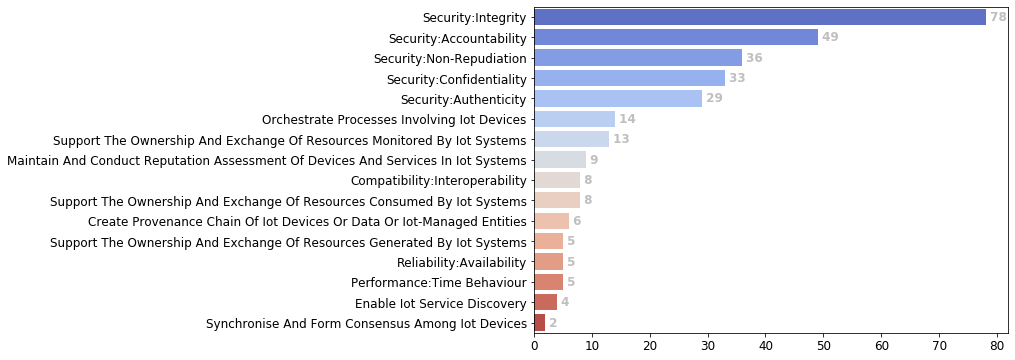

In [49]:
"""
Countplot of specific improve objective
"""
paper_imp_obj_relation = create_relation_paper_RQ(raw_df, "Improvement Objective", "Improvement Objective")

draw_countplot(paper_imp_obj_relation, "Improvement Objective", size = (8.5,6), font = 12, fig_name = "RQ1_improvement_objectives")

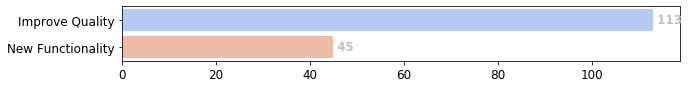

In [50]:
"""
Countplot of groups of improve objective
"""
paper_imp_cate_relation = create_relation_paper_RQ(raw_df, "Improvement Objective Category", "a")
#paper_imp_cate_relation["a"]
draw_countplot(paper_imp_cate_relation, "a", size = (10,1), fig_name = "RQ1_quality_vs_functionality")
#paper_imp_obj_relation.info()

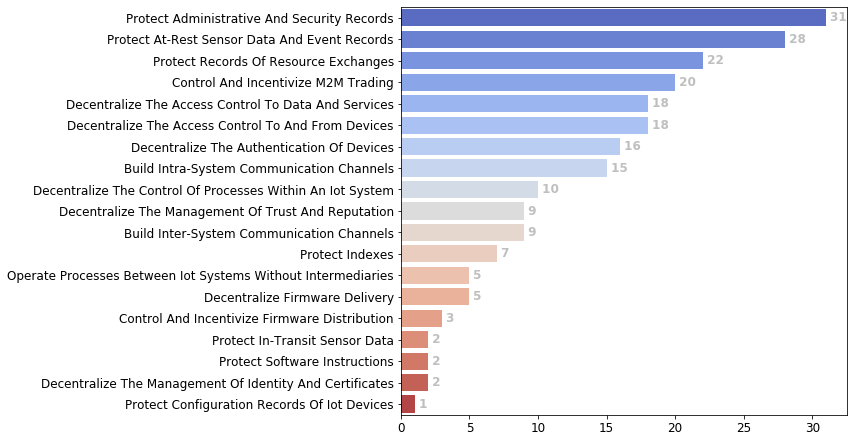

In [51]:
"""
Countplot of technical issues
"""
paper_tech_prob_relation = create_relation_paper_RQ(raw_df, "Technical Problem", "Technical Problem")
draw_countplot(paper_tech_prob_relation, "Technical Problem", size = (8, 7.5), font = 12, fig_name = "RQ1_problems")

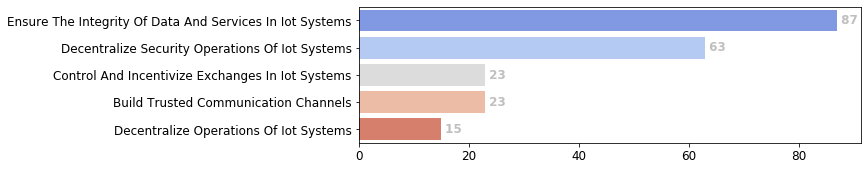

In [55]:
"""
Countplot of technical problem categories
"""
paper_prob_cate_relation = create_relation_paper_RQ(raw_df, "Technical Problem Category", "Technical Problem Category")
draw_countplot(paper_prob_cate_relation, "Technical Problem Category", size = (9,2.5), fig_name = "RQ1_problem_categories")

In [131]:
"""
Create relation between RQ1: Problem area, and RQ1: Technical issues
"""
relation_df = create_relation(data = raw_df, column_A_in_df = "Improvement Objective", column_A_display = "Improvement Objective", column_B_in_df = "Technical Problem Category", column_B_display = "Technical Problem Category")
#relation_df.groupby(["Improvement Objective", 'Technical Problem Category']).size()

def categoryToNumerical(df, series_name):
    df[series_name] = df[series_name].astype("category")
    df[series_name + " Cat"] = relation_df[series_name].cat.codes

categoryToNumerical(relation_df, "Improvement Objective")
categoryToNumerical(relation_df, "Technical Problem Category")
relation_df["Technical Problem Category"].cat.categories


Index(['build trusted communication channels',
       'control and incentivise the distribution of iot data and services',
       'decentralise the operation of iot systems',
       'decentralise the security of iot systems',
       'ensure the integrity of iot systems and their data'],
      dtype='object')

In [16]:
"""
Loads the extracted data for RQ2_1
"""

raw_path = "RQ2_RQ3/extraction_Q2_Q3_v1.0.0.xlsx"

raw_df = pd.read_excel(raw_path)
raw_df

,Paper ID,Title,Year,Venue,Type,Affected Modules in IoT Systems,Deployment of Blockchain
0,Zhang:2015:1,An IoT Electric Business Model Based on the Pr...,2015,ICIN 2015,Conference,Business process orchestrator,Cloud
1,Ouaddah:2016,FairAccess: a new Blockchain-based access cont...,2016,Security and Communication Networks,Journal,"Device, Data, and Service Authorisation",Cloud
2,Samaniego:2016:1,Using blockchain to push software-defined IoT ...,2016,ACM International Conference Proceeding Series,Conference,Communication channel,Cloud-Full -- Edge-LW
3,Ali:2017:1,The quest for fully smart autonomous business ...,2017,ACM International Conference Proceeding Series,Conference,Communication channel; business process orches...,Cloud
4,Ali:2017:2,IoT data privacy via blockchains and IPFS,2017,ACM International Conference Proceeding Series,Conference,"Sensor Data Storage or Registry; Device, Data,...",Cloud
5,Boudguiga:2017:1,Towards better availability and accountability...,2017,Proceedings of the 2nd IEEE European Symposium...,Workshop,Firmware Delivery,Cloud
6,Daza:2017:1,CONNECT: CONtextual NamE disCovery for blockch...,2017,Proceedings of IEEE International Conference o...,Conference,Service registry and matchmaker,Cloud
7,Dorri:2017:2,Towards an optimized blockchain for IoT,2017,Proceedings of the 2nd International Conferenc...,Conference,"Device, Data, and Service Authorisation",Cloud & Fog
8,Kaga:2017:1,A secure and practical signature scheme for bl...,2017,Lecture Notes in Computer Science (including s...,Journal,Interaction and incident Records,Cloud
9,Lee:2017:1,Blockchain-based secure firmware update for em...,2017,Journal of Supercomputing,Journal,Firmware Delivery,Cloud & Edge


In [17]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 7 columns):
Paper ID                           90 non-null object
Title                              90 non-null object
Year                               90 non-null int64
Venue                              90 non-null object
Type                               90 non-null object
Affected Modules in IoT Systems    90 non-null object
Deployment of Blockchain           90 non-null object
dtypes: int64(1), object(6)
memory usage: 5.0+ KB


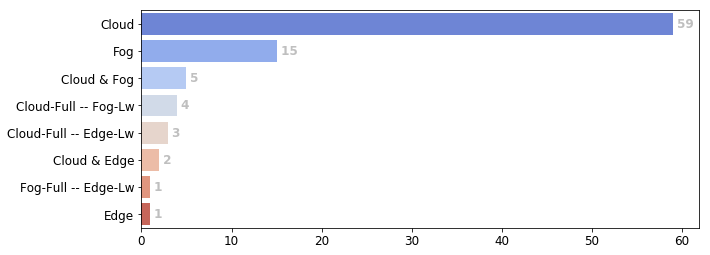

In [18]:
"""
Countplot of deployment pattern
"""
paper_deployment_relation = create_relation_paper_RQ(raw_df, "Deployment of Blockchain", "Deployment", split_sub_areas = False)

draw_countplot(paper_deployment_relation, "Deployment", size = (10,4), fig_name = "RQ2_deployment")

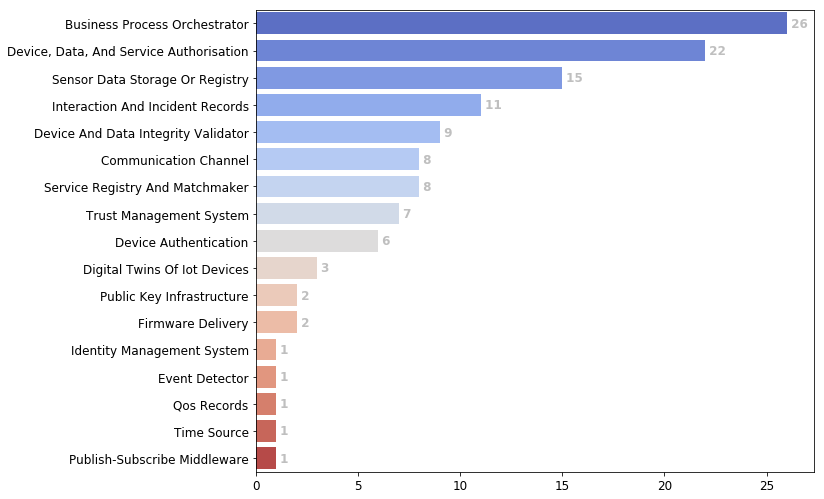

In [134]:
"""
Countplot of affected modules in IoT systems
"""
paper_module_relation = create_relation_paper_RQ(raw_df, "Affected Modules in IoT Systems", "Affected Modules", split_sub_areas = False)

draw_countplot(paper_module_relation, "Affected Modules", size = (10,8.5), fig_name = "RQ2_affected_modules")

In [135]:
"""
Loads the extracted data for RQ2_2 on on and off chain data and logic
"""

raw_path = "RQ2_RQ3/extraction_Q2_Q3_v1.0.0.xlsx"

raw_df = pd.read_excel(raw_path, sheet_name="RQ2.2")
raw_df["Off-chain data"] = raw_df["Off-chain data"].fillna("No off-chain data")
raw_df["On-chain logic"] = raw_df["On-chain logic"].fillna("No on-chain logic")
raw_df["Off-chain logic"] = raw_df["Off-chain logic"].fillna("No Off-chain logic")
raw_df

,Paper ID,Title,Year,Venue,Type,On-chain data,Off-chain data,On-chain logic,Off-chain logic
0,Zhang:2015:1,An IoT Electric Business Model Based on the Pr...,2015,ICIN 2015,Conference,Resource exchange records,No off-chain data,No on-chain logic,Business logic
1,Ouaddah:2016,FairAccess: a new Blockchain-based access cont...,2016,Security and Communication Networks,Journal,Authorisation requests and responses,No off-chain data,No on-chain logic,No Off-chain logic
2,Samaniego:2016:1,Using blockchain to push software-defined IoT ...,2016,ACM International Conference Proceeding Series,Conference,Service interaction records,No off-chain data,No on-chain logic,No Off-chain logic
3,Ali:2017:1,The quest for fully smart autonomous business ...,2017,ACM International Conference Proceeding Series,Conference,Service interaction records; Device interactio...,Smart contract repository,Business process,Smart contract management; IoT system adapter
4,Ali:2017:2,IoT data privacy via blockchains and IPFS,2017,ACM International Conference Proceeding Series,Conference,Sensor Reading Hashes; Authorisation policies;...,No off-chain data,Authorisation mechanism; Data index maintenance,No Off-chain logic
5,Boudguiga:2017:1,Towards better availability and accountability...,2017,Proceedings of the 2nd IEEE European Symposium...,Workshop,Firmware Hash (and Binary),No off-chain data,No on-chain logic,No Off-chain logic
6,Daza:2017:1,CONNECT: CONtextual NamE disCovery for blockch...,2017,Proceedings of IEEE International Conference o...,Conference,Service descriptions,No off-chain data,No on-chain logic,No Off-chain logic
7,Dorri:2017:2,Towards an optimized blockchain for IoT,2017,Proceedings of the 2nd International Conferenc...,Conference,Device interaction records; \nService interact...,No off-chain data,No on-chain logic,Enforce Access Control
8,Kaga:2017:1,A secure and practical signature scheme for bl...,2017,Lecture Notes in Computer Science (including s...,Journal,Device interaction records,No off-chain data,No on-chain logic,No Off-chain logic
9,Lee:2017:1,Blockchain-based secure firmware update for em...,2017,Journal of Supercomputing,Journal,Firmware Hash (and Binary),Firmware Binary,No on-chain logic,No Off-chain logic


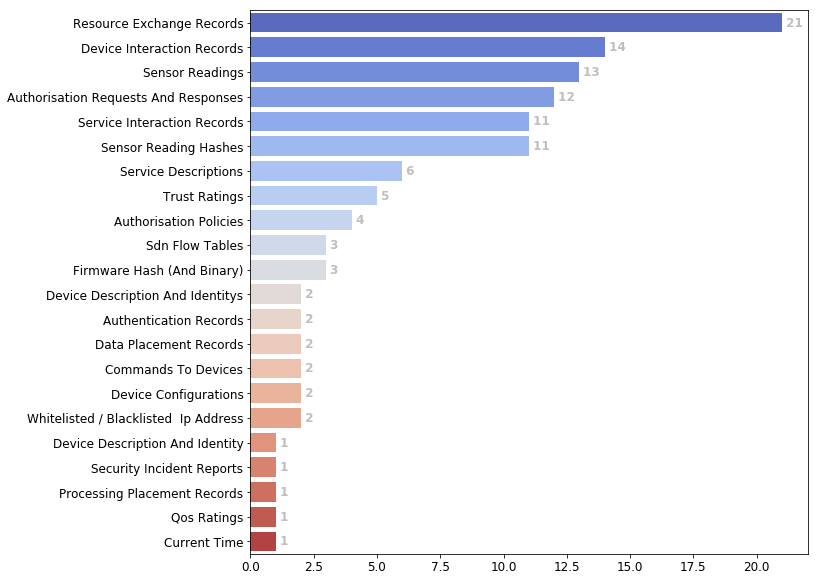

In [136]:
"""
Countplot of on-chain data
"""
paper_on_chain_data_relation = create_relation_paper_RQ(raw_df, "On-chain data", "On-chain data", split_sub_areas = False)

draw_countplot(paper_on_chain_data_relation, "On-chain data", size = (10,10), fig_name = "RQ2_on_chain_data")

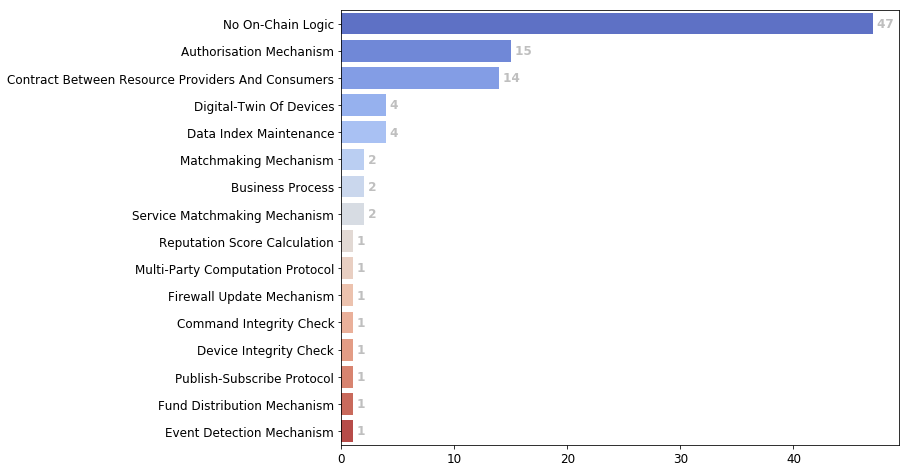

In [137]:
"""
Countplot of on-chain logic
"""


paper_on_chain_logic_relation = create_relation_paper_RQ(raw_df, "On-chain logic", "On-chain logic", split_sub_areas = False)

draw_countplot(paper_on_chain_logic_relation, "On-chain logic", size = (10,8), fig_name = "RQ2_on_chain_logic")

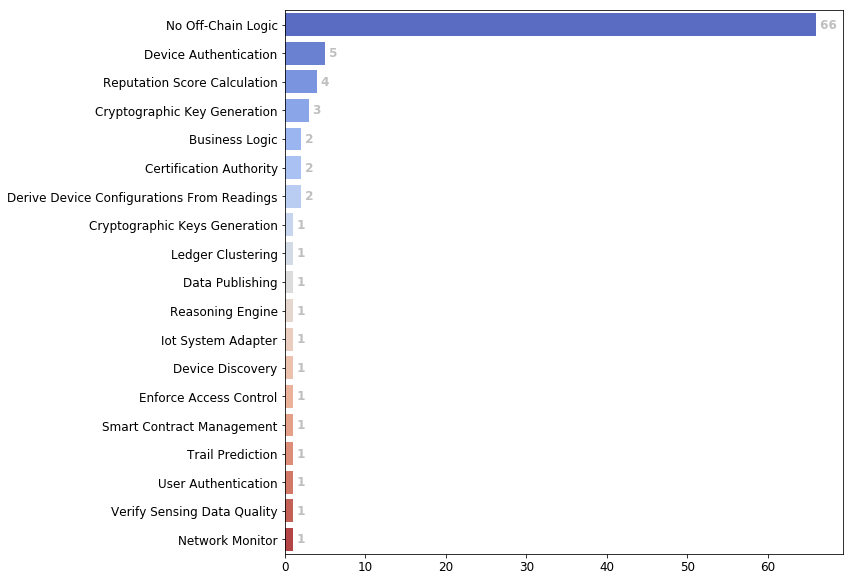

In [138]:
"""
Countplot of off-chain logic
"""


paper_on_chain_logic_relation = create_relation_paper_RQ(raw_df, "Off-chain logic", "Off-chain logic", split_sub_areas = False)

draw_countplot(paper_on_chain_logic_relation, "Off-chain logic", size = (10,10), fig_name = "RQ2_off_chain_logic")

In [19]:
"""
Loads the extracted data for RQ2_2 on on and off chain data and logic
"""

raw_path = "RQ2_RQ3/extraction_Q2_Q3_v1.0.0.xlsx"

raw_df = pd.read_excel(raw_path, sheet_name="RQ2.3")
raw_df

,Paper ID,Title,Year,Venue,Type,Number of Blockchains,Data structure of ledger,Global state in ledger,Smart contract type,Consensus scheme,Blockchain Permission Type,Key Management Mechanism,Development Technology,Pattern
0,Zhang:2015:1,An IoT Electric Business Model Based on the Pr...,2015,ICIN 2015,Conference,1,blockchain,UTXO,Installed,Proof-of-work Variant,Public,NaN,Bitcoin,blockchain -- UTXO -- Installed -- Proof-of-wo...
1,Ouaddah:2016,FairAccess: a new Blockchain-based access cont...,2016,Security and Communication Networks,Journal,1,blockchain,UTXO,NaN,Proof-of-work Variant,Public,NaN,Bitcoin,blockchain -- UTXO -- N/A -- Proof-of-work Var...
2,Samaniego:2016:1,Using blockchain to push software-defined IoT ...,2016,ACM International Conference Proceeding Series,Conference,1,blockchain,UTXO,NaN,Proof-of-work Variant,Private,NaN,MultiChain,blockchain -- UTXO -- N/A -- Proof-of-work Var...
3,Ali:2017:1,The quest for fully smart autonomous business ...,2017,ACM International Conference Proceeding Series,Conference,1,Blockchain,TX Log,installed,PBFT,Consortium,NaN,Hyperledger Fabric,Blockchain -- TX Log -- installed -- PBFT -- C...
4,Ali:2017:2,IoT data privacy via blockchains and IPFS,2017,ACM International Conference Proceeding Series,Conference,more than 2,blockchain,account,on-chain,Proof-of-work Variant; Proof-of-stake,Consortium; Private,NaN,Monax; Ethereum,blockchain -- account -- on-chain -- Proof-of-...
5,Boudguiga:2017:1,Towards better availability and accountability...,2017,Proceedings of the 2nd IEEE European Symposium...,Workshop,1,blockchain,UTXO,NaN,Proof-of-work Variant,Private,NaN,MultiChain,blockchain -- UTXO -- N/A -- Proof-of-work Var...
6,Daza:2017:1,CONNECT: CONtextual NamE disCovery for blockch...,2017,Proceedings of IEEE International Conference o...,Conference,more than 2,blockchain,UTXO,NaN,Proof-of-work Variant,Public,NaN,Bitcoin,blockchain -- UTXO -- N/A -- Proof-of-work Var...
7,Dorri:2017:2,Towards an optimized blockchain for IoT,2017,Proceedings of the 2nd International Conferenc...,Conference,2,Blockchain,UTXO,NaN,None,Public; Private,NaN,In-house BC system,Blockchain -- UTXO -- N/A -- None -- Public; P...
8,Kaga:2017:1,A secure and practical signature scheme for bl...,2017,Lecture Notes in Computer Science (including s...,Journal,1,blockchain,UTXO,NaN,Proof-of-work Variant,Public,NaN,Bitcoin,blockchain -- UTXO -- N/A -- Proof-of-work Var...
9,Lee:2017:1,Blockchain-based secure firmware update for em...,2017,Journal of Supercomputing,Journal,1,blockchain,UTXO,NaN,Proof-of-work Variant,Public,NaN,In-house BC system,blockchain -- UTXO -- N/A -- Proof-of-work Var...


In [45]:
"""
Countplot of pattern
"""


def draw_countplot(data, column, size = (10, 8), font = 12, fig_name = "fig", limit = 5):
    counts = data[column].value_counts()
    counts_lim = counts.iloc[:limit]
    data_lim = data[data[column].isin(counts_lim.index)]
    sns.countplot(y = column, data = data, orient="v", palette="coolwarm", 
              order = counts)
    #print(counts_lim.index)
    
    ax1 = plt.gca()
    ax1.yaxis.label.set_visible(False)
    ax1.xaxis.label.set_visible(False)
    plt.rcParams.update({"font.size": font})
    fig = plt.gcf()
    fig.set_size_inches(*size)
    for i, v in enumerate(data[column].value_counts()):
        ax1.text(v, i, " "+str(v), color='0.75', va='center', fontweight='bold')
    plt.show()
    fig.savefig(fig_name + ".pdf", bbox_inches='tight')

paper_pattern_relation = create_relation_paper_RQ(raw_df, "Pattern", "Pattern", split_sub_areas = False)

#paper_pattern_relation

draw_countplot(paper_pattern_relation, "Pattern", size = (10,2.5), fig_name = "RQ2_pattern")

ValueError: Image size of 127154x174 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 720x180 with 1 Axes>

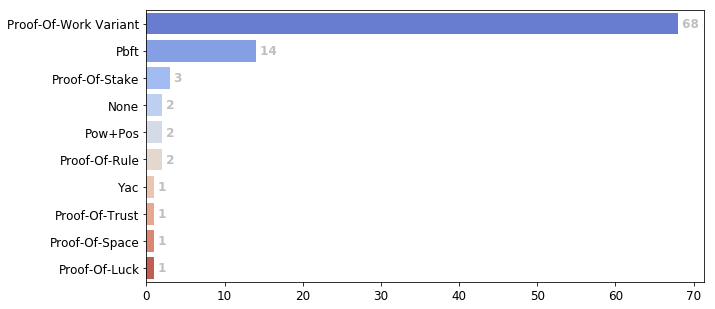

In [140]:
"""
Countplot of consensus scheme
"""


paper_on_chain_logic_relation = create_relation_paper_RQ(raw_df, "Consensus scheme", "Consensus scheme", split_sub_areas = False)

draw_countplot(paper_on_chain_logic_relation, "Consensus scheme", size = (10,5), fig_name = "RQ2_consensus_schemes")

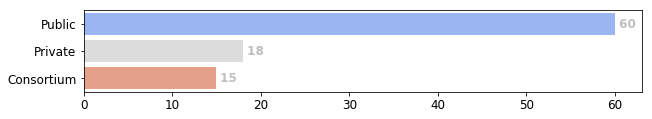

In [141]:
"""
Countplot of permission type
"""


paper_on_chain_logic_relation = create_relation_paper_RQ(raw_df, "Blockchain Permission Type", "Blockchain Permission Type", split_sub_areas = False)

draw_countplot(paper_on_chain_logic_relation, "Blockchain Permission Type", size = (10,1.5))

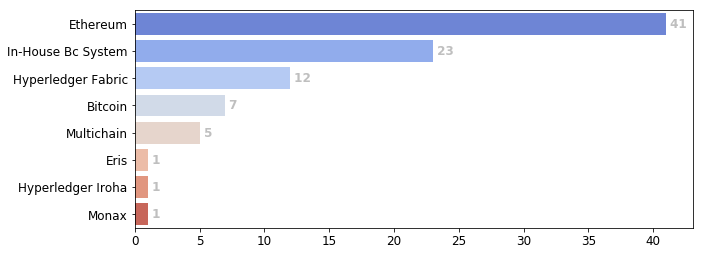

In [142]:
"""
Countplot of development technology
"""


paper_on_chain_logic_relation = create_relation_paper_RQ(raw_df, "Development Technology", "Development Technology", split_sub_areas = False)

draw_countplot(paper_on_chain_logic_relation, "Development Technology", size = (10,4), fig_name = "RQ2_dev_tech")

In [143]:
"""
Loads the extracted data for RQ3 on optimisation problems and solutions
"""

raw_path = "RQ2_RQ3/extraction_Q2_Q3_v1.0.0.xlsx"

raw_df = pd.read_excel(raw_path, sheet_name="RQ3")
raw_df

,Paper ID,Title,Year,Venue,Type,Problem,Solution
0,Zhang:2015:1,An IoT Electric Business Model Based on the Pr...,2015,ICIN 2015,Conference,Not addressed,Not addressed
1,Ouaddah:2016,FairAccess: a new Blockchain-based access cont...,2016,Security and Communication Networks,Journal,Not addressed,Not addressed
2,Samaniego:2016:1,Using blockchain to push software-defined IoT ...,2016,ACM International Conference Proceeding Series,Conference,Not addressed,Not addressed
3,Ali:2017:1,The quest for fully smart autonomous business ...,2017,ACM International Conference Proceeding Series,Conference,Not addressed,Not addressed
4,Ali:2017:2,IoT data privacy via blockchains and IPFS,2017,ACM International Conference Proceeding Series,Conference,IoT devices form different groups that belong ...,Integrate side-chains with a consortium chain.
5,Boudguiga:2017:1,Towards better availability and accountability...,2017,Proceedings of the 2nd IEEE European Symposium...,Workshop,Not addressed,Not addressed
6,Daza:2017:1,CONNECT: CONtextual NamE disCovery for blockch...,2017,Proceedings of IEEE International Conference o...,Conference,Not addressed,Not addressed
7,Dorri:2017:2,Towards an optimized blockchain for IoT,2017,Proceedings of the 2nd International Conferenc...,Conference,IoT injects too many transactions at too high ...,Replace PoW with distributed trust
8,Kaga:2017:1,A secure and practical signature scheme for bl...,2017,Lecture Notes in Computer Science (including s...,Journal,Devices might generate transactions without ow...,Integrate owners’ biometrics into the signatur...
9,Lee:2017:1,Blockchain-based secure firmware update for em...,2017,Journal of Supercomputing,Journal,Not addressed,Not addressed


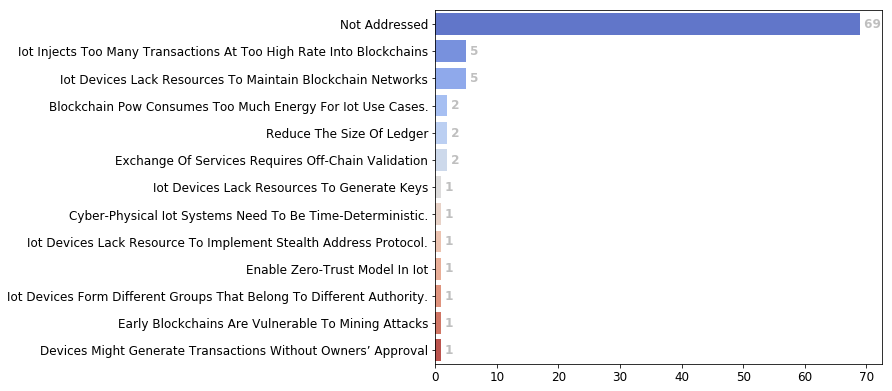

In [146]:
"""
Countplot of problem
"""


paper_on_chain_logic_relation = create_relation_paper_RQ(raw_df, "Problem", "Problem", split_sub_areas = False)

draw_countplot(paper_on_chain_logic_relation, "Problem", size = (8,6.5), fig_name = "RQ3_problems")

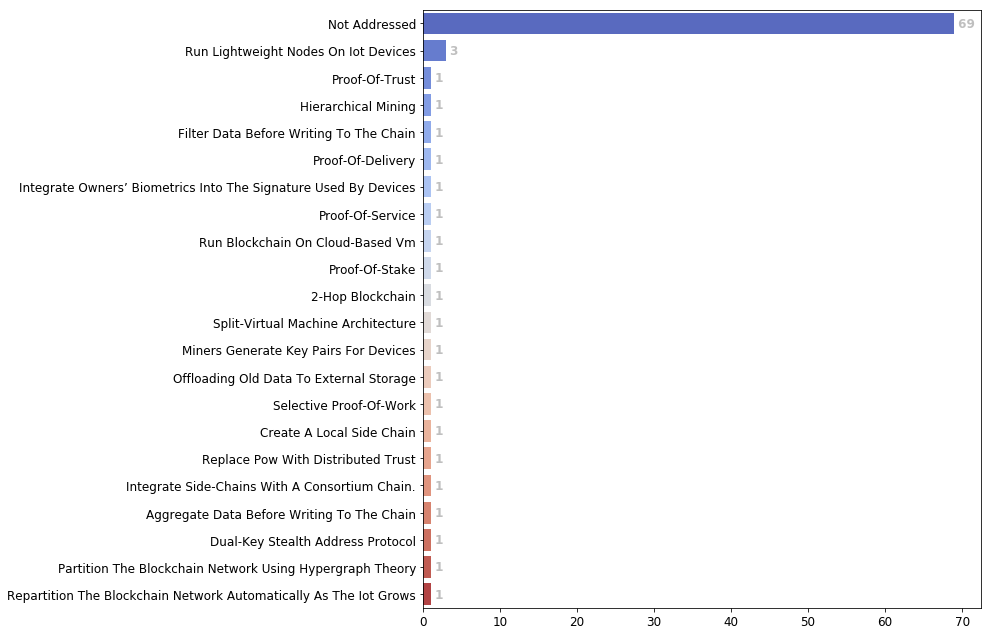

In [145]:
"""
Countplot of solution
"""


paper_on_chain_logic_relation = create_relation_paper_RQ(raw_df, "Solution", "Solution", split_sub_areas = False)

draw_countplot(paper_on_chain_logic_relation, "Solution", size = (10,11), fig_name = "RQ3_solutions")